In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier,LGBMRegressor
from lightgbm import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from lightgbm import plot_metric

In [2]:
def get_cross_score(X, y,model = None):
    if not model:
        model = LGBMRegressor(verbose = 0)

    scores = cross_val_score(model,cv = 5,X = X,y = y,scoring = "neg_root_mean_squared_error")
    scores = -1 * scores
    return scores, np.mean(scores)

def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)

def clip(f):
    def clip_f(X):
        sigma = 0.05
        mu = f(X)
        a, b = -mu/sigma, (1-mu)/sigma
        Phi_a, Phi_b = scipy.stats.norm.cdf(a), scipy.stats.norm.cdf(b)
        phi_a, phi_b = scipy.stats.norm.pdf(a), scipy.stats.norm.pdf(b)
        return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
    return clip_f

def add_pairwise_cat_interactions(df, cat_cols, sep="__",
                                  na_token="[NA]", as_category=True):
    new_cols = []
    for c1, c2 in combinations(cat_cols, 2):
        colname = f"{c1}__x__{c2}"
        s1 = df[c1].astype("string").fillna(na_token)
        s2 = df[c2].astype("string").fillna(na_token)
        df[colname] = s1.str.cat(s2, sep=sep)
        if as_category:
            df[colname] = df[colname].astype("category")
        new_cols.append(colname)
    return df

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv",index_col = "id")
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv",index_col = "id")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")
orig = []
for k in [2,10,100]:
    df = pd.read_csv(f"/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_{k}k.csv")
    orig.append(df)
orig = pd.concat(orig,axis=0)
orig['id'] = np.arange(len(orig))+test.index.max()+1
orig = orig[ train.columns ] 

cat_cols = [col for col in train.select_dtypes(include = ["object"]).columns]
for col in cat_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")
    orig[col] = orig[col].astype("category")
    


In [4]:
ADV = False
if ADV:
    
    test_adv = test.copy()
    train_adv = X.copy()
    
    train_adv["label"] = 1
    test_adv["label"] = 0
    
    combined = pd.concat([train_adv,test_adv],ignore_index = True)
    cat_cols = [col for col in combined.select_dtypes(include = ["object"]).columns]
    for col in cat_cols:
        combined[col] = combined[col].astype("category")
    
    combined = combined.sample(frac = 1)

    estimator = LGBMClassifier(random_state = 42,verbose = 0,max_depth = 6)
    X_adv = combined.drop("label",axis = 1)
    y_adv = combined["label"]
    estimator.fit(X_adv,y_adv)
    
    print(cross_val_score(estimator = estimator,
                   cv = 5,
                   X = X_adv,
                   y = y_adv))
    
    plot_importance(estimator)

BASE = False
if BASE:
    
    X = train.drop("accident_risk",axis = 1).copy()
    y = train["accident_risk"].copy()
    
    get_cross_score(X = X,y = y)

TRY_ALL = False
if TRY_ALL:
    all_df = pd.concat([train,orig],ignore_index = True)
    X = all_df.drop("accident_risk",axis = 1).copy()
    y = all_df["accident_risk"].copy()
    
    get_cross_score(X = X,y = y)

ADD_NEW_FEATURES = False
if ADD_NEW_FEATURES:
    new_train = train.copy()
    
    z = clip(f)(new_train)
    new_train["y"] = z.values
    
    
    X = new_train.drop("accident_risk",axis = 1).copy()
    y = new_train["accident_risk"].copy()
    
    print(get_cross_score(X = X,y = y))

TE_CAT = False
if TE_CAT:
    new_train = train.copy()
    for c in cat_cols:
        new = new_train.groupby(c)["accident_risk"].mean()
        new_train[f"TE_{c}"] = new_train[c].map(new)

    X = new_train.drop("accident_risk",axis = 1).copy()
    y = new_train["accident_risk"].copy()

    print(get_cross_score(X = X,y = y))

COMBINE_CAT = False
if COMBINE_CAT:
    
    new_train = train.copy()
    new_train = add_pairwise_cat_interactions(new_train,cat_cols)

    X = new_train.drop("accident_risk",axis = 1).copy()
    y = new_train["accident_risk"].copy()

    print(get_cross_score(X = X,y = y))

BOOL_TE = False
if BOOL_TE:
    new_train = train.copy()
    bool_cols = new_train.select_dtypes(include = ["bool"]).columns
    
    for bool_col in bool_cols:
        mean_col = orig.groupby(bool_col)["accident_risk"].mean()
        new_train[f"TE_{bool_col}"] = new_train[bool_col].map(mean_col)

    new_train["TE_num_reported_accidents"] = new_train.groupby("num_reported_accidents")["accident_risk"].mean()

    X = new_train.drop("accident_risk",axis = 1).copy()
    y = new_train["accident_risk"].copy()
    print(get_cross_score(X = X,y = y))

BINNING = False
if BINNING:
    new_train = train.copy()
    new_train["curvature_copy"] = new_train["curvature"]

    KF = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for tr_idx, va_idx in KF.split(new_train):
        tr = new_train.iloc[tr_idx].copy()
        va = new_train.iloc[va_idx].copy()

        X_tr = tr.drop(columns=["accident_risk"])
        y_tr = tr["accident_risk"].values
        X_va = va.drop(columns=["accident_risk"])
        y_va = va["accident_risk"].values

        kbin = KBinsDiscretizer(
            n_bins=3, encode="ordinal", strategy="quantile"  # quantile = qcut benzeri
        )
        X_tr.loc[:, "curvature_copy"] = kbin.fit_transform(
            X_tr[["curvature_copy"]]
        ).astype("int16")
        X_va.loc[:, "curvature_copy"] = kbin.transform(
            X_va[["curvature_copy"]]
        ).astype("int16")

     
        model = LGBMRegressor(verbose=0, random_state=42)

        model.fit(X_tr, y_tr)
        preds = model.predict(X_va)

        rmse = mean_squared_error(y_va, preds, squared=False)
        scores.append(rmse)

    print("Fold RMSE:", scores)
    print("MEAN RMSE:", float(np.mean(scores)))

In [5]:
z = clip(f)(train)
train["y"] = z.values

z_test = clip(f)(test)
test["y"] = z_test

X = train.drop("accident_risk",axis = 1)
y = train["accident_risk"]

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)
model = LGBMRegressor(verbose = -1,
                      random_state = 42,
                      n_estimators = 100,
                      max_depth = 6,
                      learning_rate = 0.05,
                     )

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)
model.fit(X_train,y_train,eval_metric = "rmse",eval_set = [(X_train,y_train),(X_test,y_test)])

LGBMRegressor(learning_rate=0.05, max_depth=6, random_state=42, verbose=-1)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

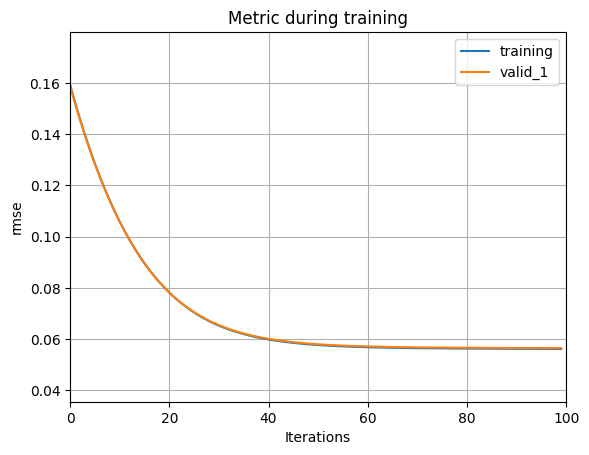

In [7]:
plot_metric(model,metric = "rmse")

In [8]:
model = LGBMRegressor(verbose = -1,
                      random_state = 42,
                      n_estimators = 100,
                      max_depth = 6,
                      learning_rate = 0.05)
model.fit(X,y)
preds = model.predict(test)

sample_submission["accident_risk"] = preds
sample_submission.to_csv("submission.csv",index = False)